## Day 30 Lecture 2 Assignment

In this assignment, we will learn about random forests. We will use the google play store dataset loaded below.

In [ ]:
!pip install category_encoders

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, classification_report, plot_confusion_matrix, roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from category_encoders.leave_one_out import LeaveOneOutEncoder
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
reviews = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv')

reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In this assignment, you will work more independently. Perform the following steps:
    
1. Select which columns are best suited to predict whether the rating is above 4.5
2. Process the data (including transforming to the correct column type, removing missing values, creating dummy variables, and removing irrelevant variables)
3. Create a random forest model and evaluate
4. Using grid search cross validation, tweak the parameters to produce a better performing model
5. Show and discuss your results

Good luck!

In [4]:
reviews_ = reviews.iloc[:, 1:8]
reviews_.dropna(inplace=True)

In [5]:
reviews_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9367 entries, 0 to 10840
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  9367 non-null   object 
 1   Rating    9367 non-null   float64
 2   Reviews   9367 non-null   object 
 3   Size      9367 non-null   object 
 4   Installs  9367 non-null   object 
 5   Type      9367 non-null   object 
 6   Price     9367 non-null   object 
dtypes: float64(1), object(6)
memory usage: 585.4+ KB


In [6]:
bin = [0.0,4.5,5.0]
category = pd.cut(reviews_.Rating, bin, labels=[0, 1])
category = category.to_frame()
category.columns = ['RatingTier']
n_reviews_ = pd.concat([reviews_, category], axis=1)

In [7]:
n_reviews_.drop('Rating', axis=1, inplace=True)

In [8]:
n_reviews_.dropna(inplace=True)

### Train-test split

In [30]:
X = n_reviews_.drop('RatingTier', axis=1)
Y = n_reviews_.RatingTier

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

In [31]:
cc = LeaveOneOutEncoder(cols=['Category', 'Reviews', 'Size', 'Installs', 'Type', 'Price'])
X_train_t = cc.fit_transform(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [32]:
rf = RandomForestClassifier()
rf.fit(X_train_t, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
X_test_t = cc.fit_transform(X_test, y_test)

test_pred_ = rf.predict(X_test_t)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [34]:
print(classification_report(y_test, test_pred_))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1469
           1       0.33      0.00      0.00       405

    accuracy                           0.78      1874
   macro avg       0.56      0.50      0.44      1874
weighted avg       0.69      0.78      0.69      1874



In [35]:
Y_bin = pd.get_dummies(y_test)
Y_bin

,0,1
1826,1,0
4223,1,0
1499,1,0
7405,0,1
8843,0,1
...,...,...
5198,1,0
7455,0,1
7200,1,0
5858,1,0


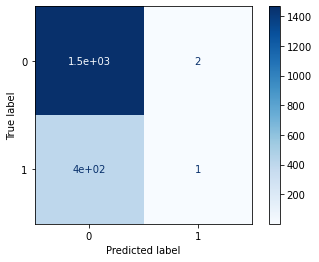

In [36]:
plot_confusion_matrix(rf, X_test_t, y_test, cmap=plt.cm.Blues)
plt.show()

In [37]:
print(f'Accuracy wrt. test set: {rf.score(X_test_t, y_test)}')

Accuracy wrt. test set: 0.7833511205976521


In [38]:
test_prob_ = rf.predict_proba(X_test_t)

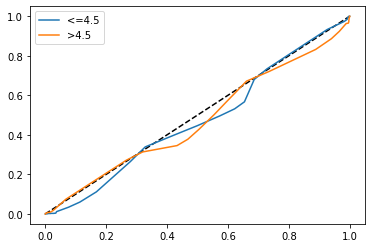

In [40]:
plt.plot([0, 1], [0, 1], 'k--')
fpr, tpr, thresholds = roc_curve(Y_bin[0], test_prob_[:,0])
plt.plot(fpr, tpr, label='<=4.5')

fpr1, tpr1, thresholds = roc_curve(Y_bin[1], test_prob_[:,1])
plt.plot(fpr1, tpr1, label='>4.5')

plt.legend()
plt.show()

In [41]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_importances

Type        0.604309
Price       0.334418
Installs    0.036483
Category    0.009170
Reviews     0.008833
Size        0.006787
dtype: float64

In [42]:
sfm = SelectFromModel(rf, threshold=0.05)
sfm.fit(X_train_t, y_train)

important = []
for feature_list_index in sfm.get_support(indices=True):
    important.append(X_train_t.columns[feature_list_index])

In [43]:
print(important)

['Type', 'Price']


### Grid Search

In [53]:
X_ = n_reviews_.drop(['RatingTier', 'Installs', 'Category', 'Reviews', 'Size'], axis=1)
Y_ = n_reviews_.RatingTier

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_,Y_,test_size=0.2)

In [54]:
cc_ = LeaveOneOutEncoder(cols=['Type', 'Price'])
X_train_t_ = cc_.fit_transform(X_train_, y_train_)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [55]:
grid = {'n_estimators':[5,25,125], 
        'max_depth':[5,10,15,25]}

rf_ = RandomForestClassifier()
rf_cv = GridSearchCV(rf_, param_grid=grid, cv=10).fit(X_train_t_, y_train_)

In [56]:
print(f'best params: {rf_cv.best_params_}')
print(f'best score: {rf_cv.best_score_}')

best params: {'max_depth': 5, 'n_estimators': 5}
best score: 1.0


In [57]:
X_test_t_ = cc_.fit_transform(X_test_, y_test_)

pred = rf_cv.predict(X_test_t_)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [59]:
print(classification_report(y_test_, pred))

              precision    recall  f1-score   support

           0       0.62      0.06      0.11      1480
           1       0.20      0.86      0.32       394

    accuracy                           0.23      1874
   macro avg       0.41      0.46      0.22      1874
weighted avg       0.53      0.23      0.16      1874



>*After selecting just Type and Price, we were able to increase the score of the random forest by ~7.1% of the original score with most of the variables as features. There was also one instance in the Grid Search that gave us a perfect score with the max depth and number of trees both at 5.*

To note: it is highly interesting as to why Price and Type both share the 93% of correlation to the Rating whether it is below or equal to 4.5 or above 4.5.